# Retail Giant Sales Forecasting Assignment

##### Global Mart is an online supergiant store that has worldwide operations. It takes orders and delivers across the globe and deals with all the major product categories — consumer, corporate & home office.
##### We have to forecast the sales of the products for the next 6 months, so that we have a proper estimate and can plan our inventory and business processes accordingly.
##### We will do TIMESERIES FORECASTING for the same.

## Initial Setup - import required packages

In [1]:
# Importing required packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Import, read and understand data : Global Superstore Dataset

In [2]:
# Importing and reading dataset

data = pd.read_csv(r'C:\\Users\\dell\\Desktop\\Global+Superstore+Data.csv')
data.head()

,Order Date,Segment,Market,Sales,Profit
0,31-07-2012,Consumer,US,2309.650,762.1845
1,05-02-2013,Corporate,APAC,3709.395,-288.7650
2,17-10-2013,Consumer,APAC,5175.171,919.9710
3,28-01-2013,Home Office,EU,2892.510,-96.5400
4,05-11-2013,Consumer,Africa,2832.960,311.5200


The store dataset has the following 5 attributes :

#Order-Date - The date on which the order was placed
#Segment	- The segment to which the product belongs
#Market	- The market to which the customer belongs
#Sales - Total sales value of the transaction
#Profit	- Profit made on the transaction

In [3]:
# Check shape of the dataset

data.shape

(51290, 5)

The dataset has got 51290 enteries and 5 features.

In [4]:
# Check the datatypes of the features and null values.

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 5 columns):
Order Date    51290 non-null object
Segment       51290 non-null object
Market        51290 non-null object
Sales         51290 non-null float64
Profit        51290 non-null float64
dtypes: float64(2), object(3)
memory usage: 2.0+ MB


Datatypes are as required and we will later convert the datatypes of Order Date to Datetime.

In [5]:
# Check the number of unique 'Segments' in the dataset and its total count.

print(data['Segment'].value_counts())
data['Segment'].unique()

Consumer       26518
Corporate      15429
Home Office     9343
Name: Segment, dtype: int64


array(['Consumer', 'Corporate', 'Home Office'], dtype=object)

So, the store caters to 3 major customer segments, i.e. Consumer, Corporate and Home Office

In [6]:
# Check the number of unique 'Market' in the dataset and its total count.

print(data['Market'].value_counts())
data['Market'].unique()

APAC      11002
LATAM     10294
EU        10000
US         9994
EMEA       5029
Africa     4587
Canada      384
Name: Market, dtype: int64


array(['US', 'APAC', 'EU', 'Africa', 'EMEA', 'LATAM', 'Canada'],
      dtype=object)

So, the store caters to 7 different geographical market segments, i.e. APAC (Asia Pacific), LATAM (Latin America), EU (European Union), US (United States), EMEA(Middle East), Africa, Canada.

## Data Preparation

Since, it is a daily transactional data, so date is present along with month and year. We will convert it to monthy data.We need to get the order date in the required month-year format to make it a monthly aggregated transaction data. For this,we will convert the order-date into a date-time format for getting it into the Month-year format.

In [7]:
# Converting 'Order Date' for object datatypes to datatime.

data['Order Date'] = pd.to_datetime(data['Order Date']).dt.to_period('m')
data.head()  # check the data set

,Order Date,Segment,Market,Sales,Profit
0,2012-07,Consumer,US,2309.650,762.1845
1,2013-05,Corporate,APAC,3709.395,-288.7650
2,2013-10,Consumer,APAC,5175.171,919.9710
3,2013-01,Home Office,EU,2892.510,-96.5400
4,2013-05,Consumer,Africa,2832.960,311.5200


In [8]:
# Check the shape of the dataset.
data.shape

(51290, 5)

Since, there are 7 market segments and 3 customer segments, so there can be 21 unique segments.
We will find the 21 unique Market Segments by combining the respective 7 geographical markets for each of 3 segments such as Home office, Consumer and Corporate.

In [9]:
# Combine 'Market' and 'Segment' to form new feature 'Unique_segment'

data['Unique_segment'] = data['Market']+data['Segment']
data.head()      # Check the dataset

,Order Date,Segment,Market,Sales,Profit,Unique_segment
0,2012-07,Consumer,US,2309.650,762.1845,USConsumer
1,2013-05,Corporate,APAC,3709.395,-288.7650,APACCorporate
2,2013-10,Consumer,APAC,5175.171,919.9710,APACConsumer
3,2013-01,Home Office,EU,2892.510,-96.5400,EUHome Office
4,2013-05,Consumer,Africa,2832.960,311.5200,AfricaConsumer


In [10]:
# Check the number of 'Unique_segment' 

data['Unique_segment'].unique()

array(['USConsumer', 'APACCorporate', 'APACConsumer', 'EUHome Office',
       'AfricaConsumer', 'USCorporate', 'EMEAConsumer',
       'LATAMHome Office', 'EUCorporate', 'EMEACorporate',
       'LATAMConsumer', 'EUConsumer', 'USHome Office', 'LATAMCorporate',
       'AfricaCorporate', 'APACHome Office', 'EMEAHome Office',
       'AfricaHome Office', 'CanadaCorporate', 'CanadaHome Office',
       'CanadaConsumer'], dtype=object)

We can see that there are 21 Unique_segments.

Due to certain unpredictable circumstances in the market, as a company, we are prioritizing only the best and most consistent market segment in terms of profitability. We want to see which market segment is the most consistently profitable. And then, we want to forecast the sales for that most consistently profitable market-segment only. This way we will know that the market region our company is investing in will be beneficial for the company as the forecasts will be reliable.

So, not all of these 21 market segments are important from the store’s point of view. We need to find out the most consistently profitable market-segment from the above given 21 'Unique_segment and forecast the sales and demand for that single market-segment only and not for all.

In [11]:
# Let's create a pivot table 'dataglobe' and compare 'Profit' of all the unique segments monthwise.

dataglobe = data.pivot_table(index='Order Date', values='Profit', columns='Unique_segment', aggfunc='sum')
dataglobe.head()  # Read the dataset

Unique_segment,APACConsumer,APACCorporate,APACHome Office,AfricaConsumer,AfricaCorporate,AfricaHome Office,CanadaConsumer,CanadaCorporate,CanadaHome Office,EMEAConsumer,...,EMEAHome Office,EUConsumer,EUCorporate,EUHome Office,LATAMConsumer,LATAMCorporate,LATAMHome Office,USConsumer,USCorporate,USHome Office
Order Date,,,,,,,,,,,,,,,,,,,,,
2011-01,2254.4898,-173.7264,230.2656,265.539,520.026,391.515,447.33,12.57,NaN,-2952.594,...,392.526,2259.8670,841.3875,2534.568,540.44312,1021.05924,-26.59744,2465.8368,643.3689,1233.9329
2011-02,4627.8531,3600.7776,617.5407,-201.888,-31.689,825.606,26.43,9.24,87.99,464.160,...,368.070,-783.9945,2234.4060,162.255,1227.86616,814.03020,-356.80440,1853.5541,421.9256,553.9467
2011-03,2337.8319,3634.9365,205.1052,919.074,244.437,83.430,82.47,NaN,84.03,706.380,...,-15.570,1273.7100,2206.5960,269.745,2427.39612,178.66400,769.88400,204.2007,127.4696,-268.9314
2011-04,633.6423,90.7521,603.8478,381.315,941.751,417.618,55.08,6.51,NaN,121.353,...,-456.510,2980.0065,981.1470,130.371,1368.82948,872.64068,-554.22952,1434.8636,494.7315,2723.4358
2011-05,3838.9500,1028.4489,102.0315,-39.981,490.650,39.180,0.87,NaN,NaN,172.554,...,-33.591,673.0080,1719.0600,443.310,1749.39200,134.87252,-397.95600,833.9433,2912.7976,145.7781


In [12]:
# Check the shape of 'dataglobe'

dataglobe.shape

(48, 21)

As we have converted daily transactional data to datetime format into monthly transactional data, so we are getting data of 48 months and there are 21 'Unique_segment'.

In [13]:
# Check the number of enteries and datatypes of each 21 features.

dataglobe.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 48 entries, 2011-01 to 2014-12
Freq: M
Data columns (total 21 columns):
APACConsumer         48 non-null float64
APACCorporate        48 non-null float64
APACHome Office      48 non-null float64
AfricaConsumer       48 non-null float64
AfricaCorporate      48 non-null float64
AfricaHome Office    48 non-null float64
CanadaConsumer       43 non-null float64
CanadaCorporate      40 non-null float64
CanadaHome Office    28 non-null float64
EMEAConsumer         48 non-null float64
EMEACorporate        48 non-null float64
EMEAHome Office      47 non-null float64
EUConsumer           48 non-null float64
EUCorporate          48 non-null float64
EUHome Office        48 non-null float64
LATAMConsumer        48 non-null float64
LATAMCorporate       48 non-null float64
LATAMHome Office     48 non-null float64
USConsumer           48 non-null float64
USCorporate          48 non-null float64
USHome Office        48 non-null float64
dtypes: float64(

Now, out of these 21 unique segments we need to find the most consistently profitable market-segment. For the same we will be using a measure called "Coefficient of Variation (CoV)". The coefficient of variation or CoV is nothing but the ratio of the standard deviation to mean for the data that it is being calculated for. 

As a better metric to compare the variance between the segments we will use the coefficient of variation which will normalise the standard deviation with the mean and give us a comparative figure on the basis of which we can identify the most profitable market segment.

We will perform the train-test split such that we take the 42 months as the train data and the 6 months as the test data. We do not want our test data to learn that how we are selecting the most consistently profitable segment.

In [14]:
# Splitting the dataset into train and test

train_len = 42
train_dataglobe = dataglobe[0:train_len]
test_dataglobe = dataglobe[train_len:]

In [15]:
# Let's create a dataframe 'cov' which consists all the 21 segments and it "Coefficient of Variation (CoV)"
# "Coefficient of Variation (CoV)" - Standard Deviation / Mean

cov = pd.DataFrame(columns=['Segment', 'CoV'])
for i in dataglobe.columns:
    temp = {"Segment":i, "CoV":np.std(train_dataglobe[i])/np.mean(train_dataglobe[i])}
    cov = cov.append(temp, ignore_index=True)

In [16]:
# Read 'cov' which is sorted by value - lowest to heighest.

cov.sort_values(by='CoV')

,Segment,CoV
0,APACConsumer,0.522725
1,APACCorporate,0.530051
12,EUConsumer,0.595215
15,LATAMConsumer,0.683770
13,EUCorporate,0.722076
16,LATAMCorporate,0.882177
14,EUHome Office,0.938072
2,APACHome Office,1.008219
18,USConsumer,1.010530
19,USCorporate,1.071829


The higher the coefficient of variation, the greater the level of dispersion around the mean. The lower the value of the coefficient of variation, the more precise the estimate.

So, in order to select consistently most profitable segment, we need to look of the segment with lowest CoV.

Here, "APACConsumer" has the lowest CoV of 0.522725, which makes it consistently most profitable segment.

In [17]:
# Now, let's create a dataframe which consists of only "APACConsumer" Unique_segment.
# "new_data" will have enteries of data of only "APACConsumer"

new_data = data.loc[data.Unique_segment == "APACConsumer"]
new_data.head()

,Order Date,Segment,Market,Sales,Profit,Unique_segment
2,2013-10,Consumer,APAC,5175.171,919.971,APACConsumer
6,2011-07,Consumer,APAC,1822.080,564.840,APACConsumer
7,2012-04,Consumer,APAC,5244.840,996.480,APACConsumer
14,2013-06,Consumer,APAC,3701.520,1036.080,APACConsumer
29,2012-02,Consumer,APAC,1878.720,582.360,APACConsumer


In [18]:
# Check the shape of the "new_data"

new_data.shape

(5699, 6)

"new_data" has got total of 5699 enteries. Dataset has got repeated enteries of months. We need to segregate the months. We will group the months and do the summation of 'Sales' and 'Profit' for each months.

In [19]:
# Group_by "Order Date" to get one entry for each month.

new_data = new_data.groupby(["Order Date"]).sum()
new_data.head()

,Sales,Profit
Order Date,,
2011-01,18821.9898,2254.4898
2011-02,23313.3531,4627.8531
2011-03,26518.4919,2337.8319
2011-04,12046.0923,633.6423
2011-05,25941.9000,3838.9500


Now, we have to do the sales forecasting. So, we do not need 'Profit' values but only need 'Sales' values for each month. 

In [20]:
# Remove 'Profit' column and only keep 'Sales' column.

new_data = new_data[['Sales']]
new_data.head()

,Sales
Order Date,
2011-01,18821.9898
2011-02,23313.3531
2011-03,26518.4919
2011-04,12046.0923
2011-05,25941.9000


In [21]:
# Check number of months.
new_data.shape

(48, 1)

Now, our timeseries dataset for the forecasting is ready with 'Sales' values of 48 months.

Let's plot the graph to observe the trend and if is there any missing value in the dataset.

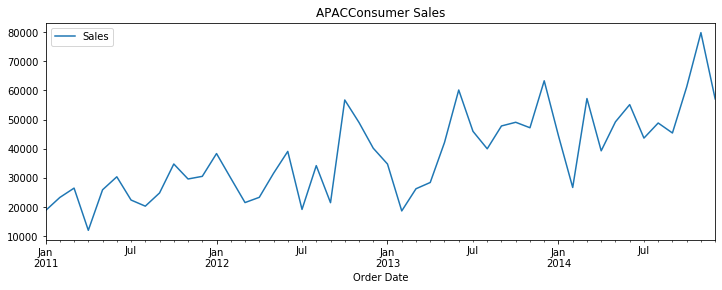

In [22]:
# Plot graph to observe the timeseries trend.

new_data.plot(figsize=(12,4))
plt.legend(loc='best')
plt.title('APACConsumer Sales')
plt.show(block=False)

Graph is continuous,there is not any missing values. There is obvious positive trend in the data, but seasonality is not obvious. We can check the same after decomposition but let's first check for the outliers.

##### OUTLIER DETECTION

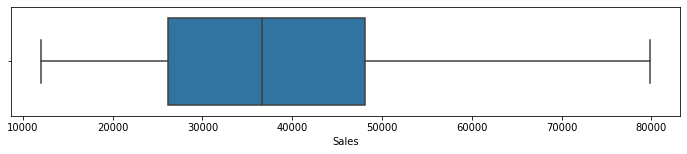

In [23]:
# Boxplot to observe outliers.

import seaborn as sns
fig = plt.subplots(figsize=(12, 2))
ax = sns.boxplot(x=new_data['Sales'],whis=1.5)

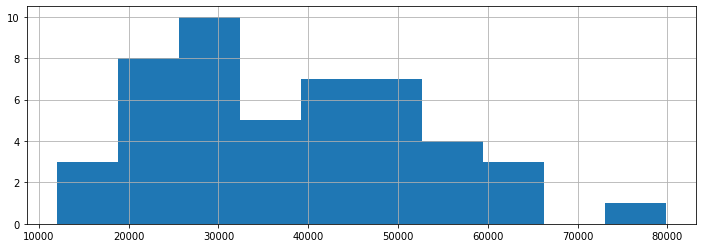

In [24]:
# Histogram to observe outliers.

fig = new_data.Sales.hist(figsize = (12,4))

From both, BOXPLOT and HISTOGRAM, we can visualize that there is no outliers.

Our time series data is ready, without and missing values or any outliers which can impact the forecast. Now, we can do the forecasting, but before that we will decompose the data and observe its trend, seasonality and residuals.

## Time Series Decomposition

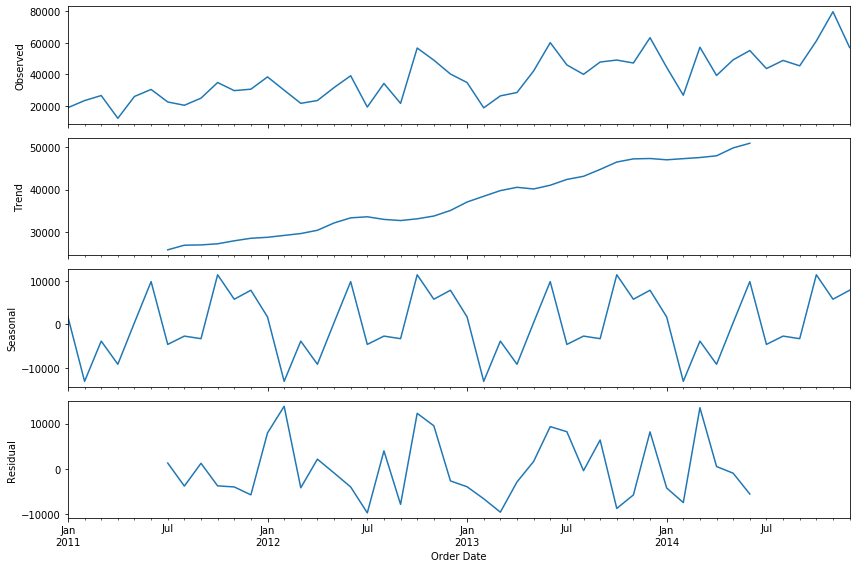

In [25]:
# Import required packages.
# Do seasonal decomposition

from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
rcParams['figure.figsize']=12,8
new_data.Sales.interpolate(inplace=True)
new_data.Sales.index=new_data.Sales.index.to_timestamp()
decomposition = seasonal_decompose(new_data.Sales)
fig = decomposition.plot()
plt.show()

After the decomposition we can observe that there is a positive linear trend in the data. Also we can observe seasonality in the data.

In [26]:
# converting datetime to timestamp - we will get a timestamp for each order date now as well.
new_data = new_data.to_timestamp()
new_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2011-01-01 to 2014-12-01
Freq: MS
Data columns (total 1 columns):
Sales    48 non-null float64
dtypes: float64(1)
memory usage: 768.0 bytes


## Build and evaluate time series forecasting
#### TRAIN-TEST SPLIT

In [27]:
# Split the dataset into train and test. We will keep first 42 months as train data and last 6 months as test data.

train_len = 42
train = new_data[0:train_len]
test = new_data[train_len:]

Now we will build and evaluate time series forecasting - We will forecast the sales for the next 6 months (test data) for APACConsumer. For forecasting, we need to check which time series model will work the best.

To choose the best model, we will compare the MAPE values of all the models. The mean absolute percentage error (MAPE) is a statistical measure of how accurate a forecast system is. Lower the MAPE, better the forecasting method, because it indicates that the forecasts are closer to the actual values.

Since, we have more than 10 historical observations, we will not do modelling using 'Simple moving Average', 'Naive method' or 'Simple Average'. As these 3 modelling techniques would not be able to forecast accurately.

Since, from the decomposition we can visualize that there is trend and seasonality in the dataset. So, if we go according to the rule, "Holt's Winter" is the best Exponential Smoothing technique and "SARIMA" is the best ARIMA techinique for forecasting. But even we will check for all the Exponential smoothing techinques as well as ARIMA technique and compare them to comeup with best techinque for forecast.

### --------------------------------------EXPONENTIAL SMOOTHING METHOD--------------------------------------

#### SIMPLE EXPONENTIAL SMOOTHING

In [28]:
# import required package
# fit the model

from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model = SimpleExpSmoothing(train['Sales'])
model_fit = model.fit(optimized = True)
print(model_fit.params)
y_hat_ses = test.copy()
y_hat_ses['ses_forecast']= model_fit.forecast(6)

{'smoothing_level': 0.2278007212960947, 'smoothing_slope': nan, 'smoothing_seasonal': nan, 'damping_slope': nan, 'initial_level': 22921.73576848832, 'initial_slope': nan, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


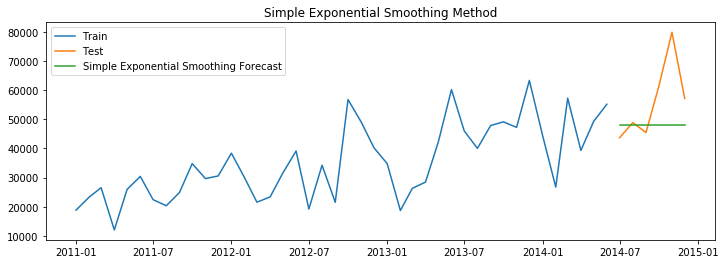

In [29]:
# plot train, test and forecast

plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_ses['ses_forecast'], label='Simple Exponential Smoothing Forecast')
plt.legend(loc='best')
plt.title('Simple Exponential Smoothing Method')
plt.show()

From the plot we can visualize that it is capturing Level, which seems close to accurate. But it is not capturing Seasonality and Trend.

In [30]:
# Calculate MAPE

mape = np.round(np.mean(np.abs(test['Sales']-y_hat_ses['ses_forecast'])/test['Sales'])*100,2)

results = pd.DataFrame({'Method':['Simple exponential smoothing forecast'],'MAPE': [mape] })
results

,Method,MAPE
0,Simple exponential smoothing forecast,15.83


MAPE value is 15.83 . It is a bit far from the actual value.

#### HOLT'S EXPONENTIAL SMOOTHING

In [31]:
# import required package
# fit the model 

from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(np.asarray(train['Sales']), seasonal_periods=12, trend='additive', seasonal=None)
model_fit = model.fit(optimized = True)
print(model_fit.params)
y_hat_holt = test.copy()
y_hat_holt['holt_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.00012098946023434364, 'smoothing_slope': 0.0001209872076472138, 'smoothing_seasonal': nan, 'damping_slope': nan, 'initial_level': 16993.615522889468, 'initial_slope': 864.7324814279958, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


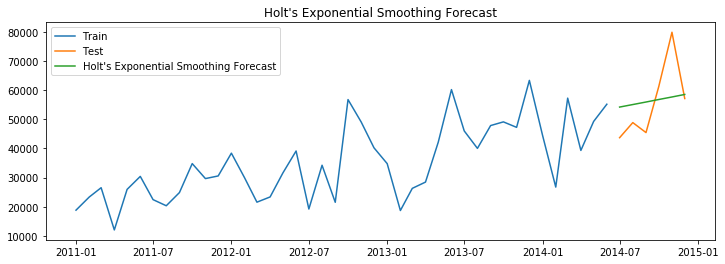

In [32]:
# Plot train, test and forecast

plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_holt['holt_forecast'], label='Holt\'s Exponential Smoothing Forecast')
plt.legend(loc='best')
plt.title('Holt\'s Exponential Smoothing Forecast')
plt.show()

From the plot we can visualize that it is capturing near accurate Level and a bit of trend. But seasonality is still not there.

In [33]:
# Calculate MAPE

mape = np.round(np.mean(np.abs(test['Sales']-y_hat_holt['holt_forecast'])/test['Sales'])*100,2)
tempResults = pd.DataFrame({'Method':['Holt\'s Exponential Smoothing Forecast'], 'MAPE':[mape]})
results = pd.concat([results, tempResults])
results = results[['Method', 'MAPE']]
results

,Method,MAPE
0,Simple exponential smoothing forecast,15.83
0,Holt's Exponential Smoothing Forecast,16.22


MAPE value is 16.22 . It is a bit far from the actual value and even greater than the MAPE value of "Simple exponential smoothing forecast". So "Holt's Exponential Smoothing Forecast" is also not going to give us accurate forecast.

####  HOLT-WINTER'S EXPONENTIAL SMOOTHING - ADDITIVE

In [34]:
# import required package
# fit the model

y_hat_hwa = test.copy()
model = ExponentialSmoothing(np.asarray(train['Sales']), seasonal_periods=12, trend='add', seasonal='add')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwa['hw_forecast'] = model_fit.forecast(len(test))

{'smoothing_level': 0.0001589669516769991, 'smoothing_slope': 0.0001589634465628399, 'smoothing_seasonal': 0.0, 'damping_slope': nan, 'initial_level': 30098.128863938822, 'initial_slope': 706.4480227671595, 'initial_seasons': array([ -9376.90367465, -19670.93673497, -12143.17512827, -19934.58098928,
        -9267.46276557,  -1002.58463365, -14271.92730198, -12910.99936781,
       -13416.83029752,   1031.7725666 ,  -4569.49935944,  -2637.79674903]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


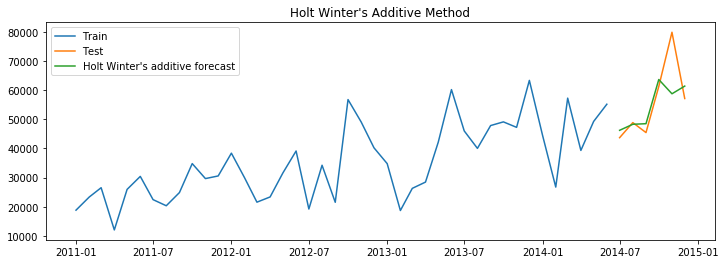

In [35]:
# Print train, test and forecast

plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_hwa['hw_forecast'], label='Holt Winter\'s additive forecast')
plt.legend(loc='best')
plt.title('Holt Winter\'s Additive Method')
plt.show()

Plot shows that it is capturing Level, Trend as well as Seasonality. All the three components seems to be forecasted accurately.

In [36]:
# Calculate MAPE

mape = np.round(np.mean(np.abs(test['Sales']-y_hat_hwa['hw_forecast'])/test['Sales'])*100,2)
tempResults = pd.DataFrame({'Method':['Holt Winter\'s Additive Method'], 'MAPE':[mape]})
results = pd.concat([results, tempResults])
results = results[['Method', 'MAPE']]
results

,Method,MAPE
0,Simple exponential smoothing forecast,15.83
0,Holt's Exponential Smoothing Forecast,16.22
0,Holt Winter's Additive Method,8.59


It's MAPE value is 8.59. It is lowest of all the methods we have checked till now. It is closest to the actual value.

####  HOLT-WINTER'S EXPONENTIAL SMOOTHING - MULTIPLICATIVE

In [37]:
# import required package
# fit the model

y_hat_hwm = test.copy()
model = ExponentialSmoothing(np.asarray(train['Sales']), seasonal_periods =12, trend='add', seasonal='mul')
model_fit = model.fit(optimized=True)
print(model_fit.params)
y_hat_hwm['hw_forecast'] = model_fit.forecast(6)

{'smoothing_level': 2.4246805508010233e-08, 'smoothing_slope': 2.2789607342325968e-08, 'smoothing_seasonal': 7.329220477159925e-08, 'damping_slope': nan, 'initial_level': 34110.96530647067, 'initial_slope': 730.4171503865401, 'initial_seasons': array([0.71585326, 0.48620509, 0.682037  , 0.53147223, 0.73796092,
       0.90143417, 0.62469806, 0.65703816, 0.64896026, 0.93177386,
       0.82774596, 0.88436913]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


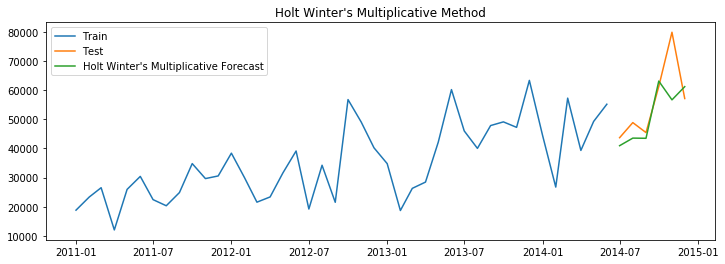

In [38]:
# Plot train, test and forecast

plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_hwm['hw_forecast'], label ='Holt Winter\'s Multiplicative Forecast')
plt.legend(loc='best')
plt.title('Holt Winter\'s Multiplicative Method')
plt.show()

This method is also capturing all the three components i.e Level, Trend and Seasonality. Trend seems to be under predicted as compared to "Holt Winter's Additive Method".

In [39]:
# Calculate MAPE

mape = np.round(np.mean(np.abs(test['Sales']-y_hat_hwm['hw_forecast'])/test['Sales'])*100,2)
tempResults = pd.DataFrame({'Method':['Holt Winter\'s Multiplicative Method'], 'MAPE':[mape]})
results = pd.concat([results, tempResults])
results = results[['Method', 'MAPE']]
results

,Method,MAPE
0,Simple exponential smoothing forecast,15.83
0,Holt's Exponential Smoothing Forecast,16.22
0,Holt Winter's Additive Method,8.59
0,Holt Winter's Multiplicative Method,10.12


It's MAPE value is 10.12 . It is more than "Holt Winter's Additive Method" but less than "Simple exponential" and "Holt's  method". 

So, till now we have build the model on four smoothing forecasting techniques and we have found out that "Holt Winter's Additive Method" seems to be most promising method for forecasting as it's MAPE value is the least.

 So, we can say that "Holt Winter's Additive Method" forecast with least MAPE value will be able to predict the sales closer to the actual values. This also matches our hypothesis, as before modelling we had thought of "Holt Winter's Method" as the best smoothing method for forecast, as it works best for data with trend and seasonality.

### --------------------------------------AUTOREGRESSIVE METHODS--------------------------------------

Two fundamental assumptions to build autoregressive model are:-
    # STATIONARITY - Statistical properties like mean, variance and covariance will be same throughout the series, irrespec--tive of the  time at which we observe them.
    # AUTOCORRELATION - Capturing how the movement of past observation and future observation are related.

First we will check if the data is stationary or not.

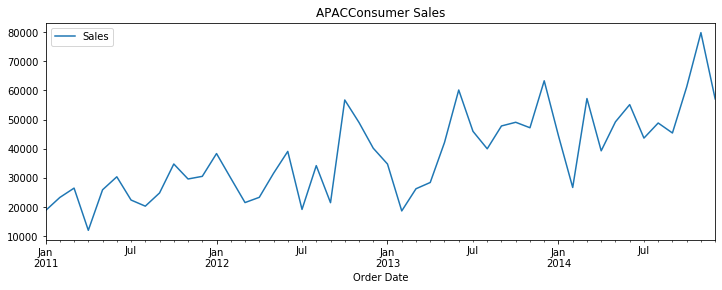

In [40]:
# Stationarity vs Non-Stationarity
# Let's plot to observe trend, mean and variance

new_data['Sales'].plot(figsize=(12,4))
plt.legend(loc='best')
plt.title('APACConsumer Sales')
plt.show(block=False)

From the graph we can clearly see the trend - Average is increasing, so, mean is not constant. Fluctuation(variance) are also not the same.

Along with the graph, we can also read some statistical values. We will do Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test on the data to see if it is stationary or not.

#KWAITKOWSKI-PHILLIPS-SCHMIDT-SHIN (KPSS) TEST

#Null Hypothesis (H0): The series is stationary = p−value>0.05
#Alternate Hypothesis (H1): The series is not stationary = p−value=<0.05

#### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

In [41]:
# import packages
# read statistical values

from statsmodels.tsa.stattools import kpss

kpss_test = kpss(new_data['Sales'])
print('KPSS Statistics:%f'% kpss_test[0])
print('Critical Values @ 0.05:%.2f'%kpss_test[3]['5%'])
print('p-value:%f'%kpss_test[1])

KPSS Statistics:0.577076
Critical Values @ 0.05:0.46
p-value:0.024720


p-value is 0.024720, which is less than 0.05. Hence, dataset is not stationary.

In order to make dataset stationary first we will do BoxCox  Transformation to make variance constant and then we can do Differencing to remove trend. We will perform the box-cox on the entire dataset of the market segment and then train-test split it again before proceeding to the ARIMA set of methods.

We will do boxcox transformation with lamda=0. The Lamda value indicates the power to which all data should be raised.  We have considered lamda=0 as the optimal value, which we have assumed will result in the best approximation of a normal distribution curve. For λ = 0, the natural log of the data is taken, i.e log(y). 

#### BoxCox  Transformation to make variance constant

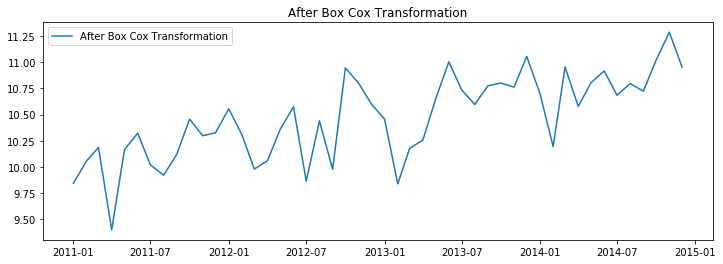

In [42]:
# boxcox transformation with lamda=0

from scipy.stats import boxcox  # import library

data_boxcox = pd.Series(boxcox(new_data['Sales'], lmbda=0), index=new_data.index)    # lamda = 0 implies log transformation 
plt.figure(figsize=(12,4))                                                           # plot the graph
plt.plot(data_boxcox, label='After Box Cox Transformation')
plt.legend(loc='best')
plt.title('After Box Cox Transformation')
plt.show()

We have treated the variance, but trend is still there and we will do differencing to remove trend and make the mean constant.

#### Differencing to remove trend

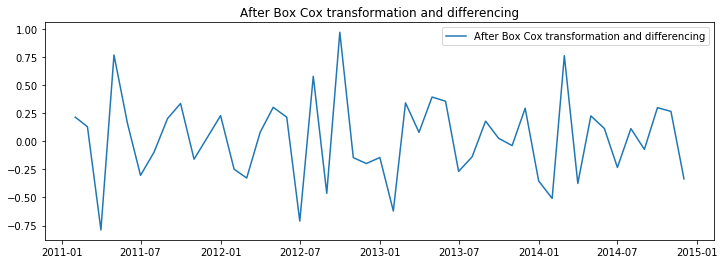

In [43]:
# Differencing-to remove the trend & seasonality - stablises the mean.
# Compute the difference between consecutive observations.

data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), new_data.index)    # differencing consecutive observations 
plt.figure(figsize=(12,4))                                                         # plot the graph
plt.plot(data_boxcox_diff, label='After Box Cox transformation and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transformation and differencing')
plt.show()

Visually the plot seems much more stationary - i.e variance and trend has been eliminated. Now, mean would be constant, but we will check stationarity using Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test. 

Since we have done differencing there must be a null/ NaN value in the dateset and we need to remove that null values, otherwise we won't be able to do further forecasting.

In [44]:
# Drop null values

data_boxcox_diff.dropna(inplace=True)

#### Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test

In [45]:
# KPSS test after boxcox transformation and differencing.

kpss_test = kpss(data_boxcox_diff)
print('KPSS Statistics:%f'%kpss_test[0])
print('Critical Values @ 0.05:%.2f'%kpss_test[3]['5%'])
print('p-value:%f'% kpss_test[1])

KPSS Statistics:0.156456
Critical Values @ 0.05:0.46
p-value:0.100000


Now, we are getting p-value=0.1 which is more than 0.05. It means now data is stationary.

In [46]:
# Dividing data_boxcox into train and test

train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]

# Dividing data_boxcox_diff into train and test

train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]

Out dataset is stationary now. So, we can start forecasting the sales for the most profitable market segment using ARIMA set of techniques.

We will use following 3 parameters:
#p : 1 : Highest lag included in the regression model.
#d : 1 : Degree of differencing to make the series stationary.
#q : 1 : No. of past error terms included in the regression model.

#### SIMPLE AUTOREGRESSIVE MODEL (AR)
It models future observation as linear regression of one or more past observations.

In [47]:
# fit the model with lag order:p as 1

from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_data_boxcox_diff, order=(1, 0, 0)) 
model_fit = model.fit()
print(model_fit.params)

const      0.024255
ar.L1.y   -0.406729
dtype: float64


In [48]:
# Recover Original time series

y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])

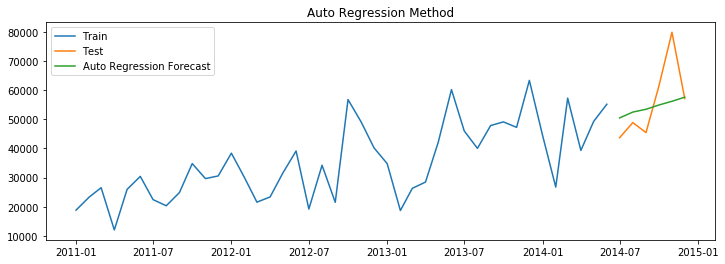

In [49]:
# Plot Train, Test and Forecast

plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_ar['ar_forecast'][test.index.min():], label='Auto Regression Forecast')
plt.legend(loc='best')
plt.title('Auto Regression Method')
plt.show()

Plot is showing that it is capturing level and trend but no seasonality.

In [50]:
# Calculate MAPE

mape = np.round(np.mean(np.abs(test['Sales']-y_hat_ar['ar_forecast'][test.index.min():])/test['Sales'])*100,2)
tempResults = pd.DataFrame({'Method':['Autoregression method(AR)'], 'MAPE':[mape]})
results = pd.concat([results, tempResults])
results = results[['Method', 'MAPE']]
results

,Method,MAPE
0,Simple exponential smoothing forecast,15.83
0,Holt's Exponential Smoothing Forecast,16.22
0,Holt Winter's Additive Method,8.59
0,Holt Winter's Multiplicative Method,10.12
0,Autoregression method(AR),13.56


It's MAPE value is 13.56, which is more than "Holt-Winter's" but less than "Simple Exponential Smooting" and "Holt's method".

#### MOVING AVERAGE MODEL(MA)
Models future forecast using past forecast errors in a regression like model

In [51]:
# fit the model with window size:q as 1

model = ARIMA(train_data_boxcox_diff, order=(0,0,1))
model_fit = model.fit()
print(model_fit.params)

const      0.021415
ma.L1.y   -1.000000
dtype: float64


In [52]:
# Recover original time series

y_hat_ma = data_boxcox_diff.copy()
y_hat_ma['ma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox_diff'].cumsum()
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(data_boxcox[0])
y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_forecast_boxcox'])

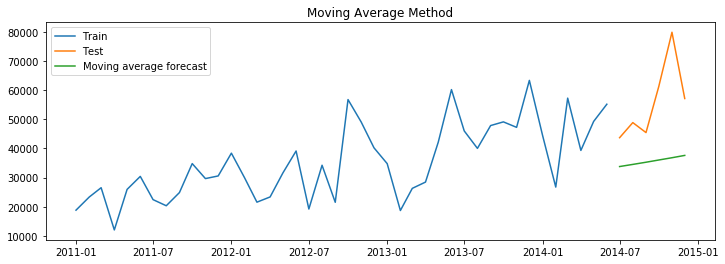

In [53]:
# Plot Train, Test and Forecast

plt.figure(figsize=(12,4))
plt.plot(new_data['Sales'][:train_len], label='Train')
plt.plot(new_data['Sales'][train_len:], label='Test')
plt.plot(y_hat_ma['ma_forecast'][test.index.min():], label='Moving average forecast')
plt.legend(loc='best')
plt.title('Moving Average Method')
plt.show()

It is capturing trend but it is underpredicting the level. Level does not seems accurate. It is also not capturing seasonality.

In [54]:
# Calculate MAPE

mape = np.round(np.mean(np.abs(test['Sales']-y_hat_ma['ma_forecast'][test.index.min():])/test['Sales'])*100,2)
tempResults = pd.DataFrame({'Method':['Moving Average method (MA)'], 'MAPE':[mape]})
results = pd.concat([results, tempResults])
results = results[['Method', 'MAPE']]
results

,Method,MAPE
0,Simple exponential smoothing forecast,15.83
0,Holt's Exponential Smoothing Forecast,16.22
0,Holt Winter's Additive Method,8.59
0,Holt Winter's Multiplicative Method,10.12
0,Autoregression method(AR),13.56
0,Moving Average method (MA),33.93


It's MAPE value is 33.93 which is much more than rest of the methods and actual value. This model is totally unsuitable for forecasting.

#### AUTOREGRESSION MOVING AVERAGE METHOD (ARMA)

Models future observations as linear regression of - One or more past observations, Past forecast errors.

In [55]:
# fit the model with lag order:p as 1, and window size:q as 1

model = ARIMA(train_data_boxcox_diff, order=(1,0,1))
model_fit = model.fit()
print(model_fit.params)

const      0.02147
ar.L1.y    0.07458
ma.L1.y   -1.00000
dtype: float64


In [56]:
# Recover original timeseries

y_hat_arma = data_boxcox_diff.copy()
y_hat_arma['arma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox_diff'].cumsum()
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox'].add(data_boxcox[0])
y_hat_arma['arma_forecast'] = np.exp(y_hat_arma['arma_forecast_boxcox'])

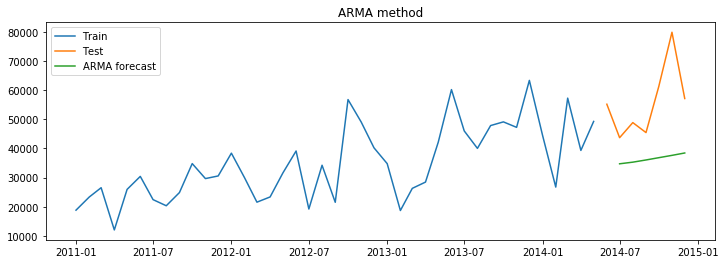

In [57]:
# Plot train, test and forecast

plt.figure(figsize=(12,4))
plt.plot(new_data['Sales'][:train_len-1], label='Train')
plt.plot(new_data['Sales'][train_len-1:], label='Test')
plt.plot(y_hat_arma['arma_forecast'][test.index.min():], label='ARMA forecast')
plt.legend(loc='best')
plt.title('ARMA method')
plt.show()

It is capturing trend but it is underpredicting the level. Level does not seems accurate. It is also not capturing seasonality just like "MA method".

In [58]:
# Calculate MAPE

mape = np.round(np.mean(np.abs(test['Sales']-y_hat_arma['arma_forecast'][train_len-1:])/test['Sales'])*100,2)
tempResults = pd.DataFrame({'Method':['Autoregressive moving average (ARMA) method'], 'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'MAPE']]
results

,Method,MAPE
0,Simple exponential smoothing forecast,15.83
0,Holt's Exponential Smoothing Forecast,16.22
0,Holt Winter's Additive Method,8.59
0,Holt Winter's Multiplicative Method,10.12
0,Autoregression method(AR),13.56
0,Moving Average method (MA),33.93
0,Autoregressive moving average (ARMA) method,32.40


It's MAPE value is 32.40 which is much more than rest of the methods and actual value and is close to "MA method". This model is totally unsuitable for forecasting.

#### AUTOREGRESSIVE INTEGRATED MOVING AVERAGE (ARIMA)

In [59]:
# fit the model with lag order:p as 1, degree of defferencing :1 and window size:q as 1

model = ARIMA(train_data_boxcox, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.params)

const        0.02147
ar.L1.D.y    0.07458
ma.L1.D.y   -1.00000
dtype: float64


In [60]:
# Recover origingal time series forecast

y_hat_arima = data_boxcox_diff.copy()
y_hat_arima['arima_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox_diff'].cumsum()
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox'].add(data_boxcox[0])
y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])

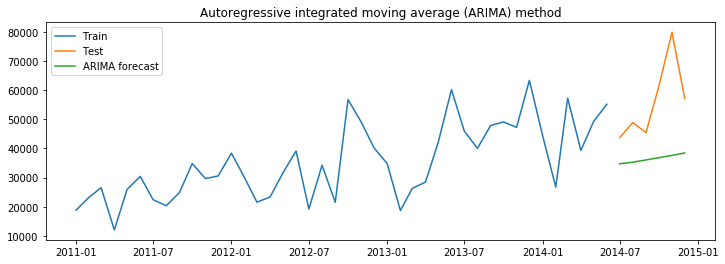

In [61]:
# Plot Train, Test, Forecast

plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_arima['arima_forecast'][test.index.min():], label='ARIMA forecast')
plt.legend(loc='best')
plt.title('Autoregressive integrated moving average (ARIMA) method')
plt.show()

It is capturing trend but it is underpredicting the level. Level does not seems accurate. It is also not capturing seasonality just like "MA method" and "ARMA method".

In [62]:
# Calculate MAPE
#y_hat_ar['ar_forecast']

mape = np.round(np.mean(np.abs(test['Sales']-y_hat_arima['arima_forecast'][test.index.min():])/test['Sales'])*100,2)
#mape = np.round(np.mean(np.abs(test['Sales']-y_hat_ar['ar_forecast'][test.index.min():])/test['Sales'])*100,2)
tempResults = pd.DataFrame({'Method':['Autoregressive integrated moving average (ARIMA) method'],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'MAPE']]
results

,Method,MAPE
0,Simple exponential smoothing forecast,15.83
0,Holt's Exponential Smoothing Forecast,16.22
0,Holt Winter's Additive Method,8.59
0,Holt Winter's Multiplicative Method,10.12
0,Autoregression method(AR),13.56
0,Moving Average method (MA),33.93
0,Autoregressive moving average (ARMA) method,32.40
0,Autoregressive integrated moving average (ARIM...,32.40


It's MAPE value is 32.40 which is much more than rest of the methods and actual value and is close to "MA method" and similar to "ARMA method". This model is totally unsuitable for forecasting.

#### SEASONAL AUTOREGRESSIVE INTEGRATED MOVING AVERAGE (SARIMA)

In [63]:
# fit the model with order(p,d,q) as (1,1,1) and seasonal_order(P,D,Q)m as (1,1,0,12)

from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data_boxcox, order=(1, 1, 1), seasonal_order=(1, 1, 0, 12)) 
model_fit = model.fit()
print(model_fit.params)

ar.L1      -0.039748
ma.L1      -0.994216
ar.S.L12   -0.485844
sigma2      0.082144
dtype: float64


In [64]:
# Recover original timeseries forecast

y_hat_sarima = data_boxcox_diff.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

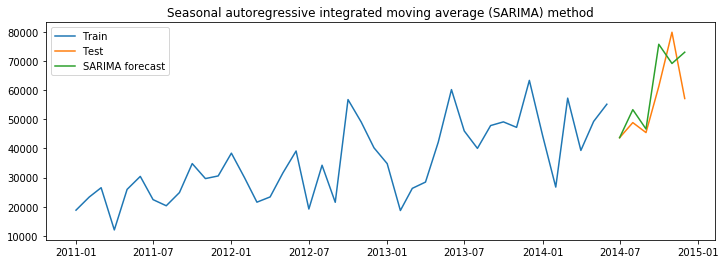

In [65]:
# Plot Train, Test and Forecast

plt.figure(figsize=(12,4))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test.index.min():], label='SARIMA forecast')
plt.legend(loc='best')
plt.title('Seasonal autoregressive integrated moving average (SARIMA) method')
plt.show()

Plot shows that this method is capturing all the three components of the time series very accurately i.e Level, Trend and Seasonality. This model could be suitable for forecasting, but let's check MAPE first. 

In [66]:
# Calculate MAPE

mape = np.round(np.mean(np.abs(test['Sales']-y_hat_sarima['sarima_forecast'][test.index.min():])/test['Sales'])*100,2)

tempResults = pd.DataFrame({'Method':['Seasonal autoregressive integrated moving average (SARIMA) method'],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'MAPE']]
results

,Method,MAPE
0,Simple exponential smoothing forecast,15.83
0,Holt's Exponential Smoothing Forecast,16.22
0,Holt Winter's Additive Method,8.59
0,Holt Winter's Multiplicative Method,10.12
0,Autoregression method(AR),13.56
0,Moving Average method (MA),33.93
0,Autoregressive moving average (ARMA) method,32.40
0,Autoregressive integrated moving average (ARIM...,32.40
0,Seasonal autoregressive integrated moving aver...,12.78


It's MAPE value is 12.78, which is least and closest to the actual value as compared to rest of the ARIMA set of techniques.

Now, we have build the model on five Autoregressive forecasting techniques and we have found out that "SARIMA" method seems to be most promising method for forecasting as it's MAPE value is the least among all the five autoregressive forecasting techniques.

So, we can say that "SARIMA" forecast with least MAPE value is able to predict the sales closer to the actual values. This also matches our hypothesis, as before modelling we had thought of "SARIMA" as the best ARIMA set of techniques for forecast, as it works best for data with trend and seasonality.

Finally, out of all the nine forecasting methods in the smoothing technique as well as the ARIMA set of techniques, best forecasting method is "Holt Winter's Additive Method" with least MAPE value of 8.59 and being able to predict the sales closer to the actual values and as it's plot shows that it is capturing Level, Trend and Seasonality very accurately.

We can now relay on "Holt Winter's Additive Method" to do the forecasting of next 6 months, as it's MAPE value is the lowest and it can easily predict sales closer to the actual values.